# Network Architecture: Depth vs Width

In this notebook, you will explore how the architecture of a neural network, specifically its **depth** (number of layers) and **width** (number of neurons per layer), affects its ability to learn.

## Setup

### Import Libraries

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from torchvision import datasets
from torchvision import transforms

from pathlib import Path

from torch.utils.data import random_split
import pandas as pd
import owncloud

### Utility Functions

In [2]:
def train(model: nn.Module, features_train: torch.Tensor, labels_train: torch.Tensor, learning_rate = 0.01, nepochs = 50) -> None:

    loss_function = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    losses = []
    accuracies = []
    for epoch in range(nepochs):
        optimizer.zero_grad()

        output = model.forward(features_train)

        loss = loss_function(output, labels_train)

        loss.backward()

        optimizer.step()

        losses.append(loss.item())
        accuracy = utils.calculate_accuracy(model, features_train, labels_train, verbose = False)
        accuracies.append(accuracy)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, Loss: {loss:.2f}, Train accuracy: {accuracy:.2f}")


    return losses, accuracies

def calculate_accuracy(model: nn.Module, features: torch.Tensor, labels: torch.Tensor, verbose = True) -> torch.Tensor:

    output = model(features)
    accuracy = (labels == torch.argmax(output, dim=1)).sum()/len(labels)
    if verbose:
        print(f'Accuracy: {(accuracy*100).item()}')
    return (accuracy*100).item()

def plot_performance_training(losses, accuracies) -> None:

    fig, axes = plt.subplots(ncols = 2, figsize = (6, 3))

    axes[0].plot(losses)
    axes[0].set_title('Loss throughout training')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Cross-entropy loss')

    axes[1].plot(accuracies)
    axes[1].set_title('Accuracy on training data')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')

    fig.tight_layout()

class utils:
    train = train
    calculate_accuracy = calculate_accuracy
    plot_performance_training = plot_performance_training

### Download Data

In this notebook, we will use the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) image dataset. It contains images from 10 classes:
- Airplane
- Automobile
- Bird
- Cat
- Deer
- Dog
- Frog
- Horse
- Ship
- Truck

The task of our network will be to correctly identify which of these 10 classes an image belongs to. Run the cells below to download and prepare the data for training.

In [4]:
mean_cifar10 = (0.4914, 0.4822, 0.4465)
std_cifar10 = (0.2023, 0.1994, 0.2010)

# NOTE: Look up how the mean and std values for normalization are calculated exactly. Simply mean and std across all pixels and images in dataset?
train_data = datasets.CIFAR10(
    download=False,
    root="data",
    train=True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean_cifar10, std_cifar10)
    ])
)

test_data = datasets.CIFAR10(
    download=False,
    root="data",
    train=False,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean_cifar10, std_cifar10)
    ])
)

/home/atleeri/repositories/Intro-to-Deep-Learning-with-PyTorch/.pixi/envs/default/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Extract images and labels, normalize them, and flatten images to vectors for training.

In [5]:
# extract train data
features_train = torch.tensor(train_data.data) # get images used for training and put them in tensor
features_train = features_train.flatten(start_dim=1) # flatten images (n_images, 32, 32, 3) -> (n_images, 3072)
features_train = features_train / 255.0 # normalize pixel values from [0, 255] to [0, 1]

fraction_to_use = 0.2
n_to_use = int(len(features_train)*fraction_to_use)

features_train = features_train[:n_to_use]
labels_train = torch.tensor(train_data.targets)[:n_to_use]

# extract test data
features_test = torch.tensor(test_data.data) # get images used for training and put them in tensor
features_test = features_test.flatten(start_dim=1) # flatten images (n_images, 32, 32, 3) -> (n_images, 3072)
features_test = features_test / 255.0 # normalize pixel values from [0, 255] to [0, 1]

n_to_use = int(len(features_test)*fraction_to_use)

features_test = features_test[:n_to_use]
labels_test = torch.tensor(test_data.targets)[:n_to_use]


print(f"features_train shape: {features_train.shape}")
print(f"features_test shape: {features_test.shape}")
print(f"features_train min/max: {features_train.min():.2f} / {features_train.max():.2f}")

features_train shape: torch.Size([10000, 3072])
features_test shape: torch.Size([2000, 3072])
features_train min/max: 0.00 / 1.00


**Visualize Sample Images From CIFAR10 Dataset**

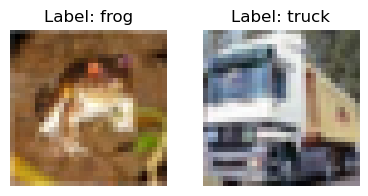

In [6]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Plot two sample images
fig, axes = plt.subplots(1, 2, figsize=(4, 2))

for i, ax in enumerate(axes):
    ax.imshow(train_data.data[i])
    ax.set_title(f"Label: {class_names[train_data.targets[i]]}")
    ax.axis('off')

fig.tight_layout()

### Download Results from Pretrained Models

In [7]:
Path('data').mkdir(exist_ok=True, parents=True)
Path('models').mkdir(exist_ok=True, parents=True)

owncloud.Client.from_public_link('https://uni-bonn.sciebo.de/s/b3AZ7jJNeXKHELp').get_file('/', f'data/train_perfomance.csv')

owncloud.Client.from_public_link('https://uni-bonn.sciebo.de/s/yADoTYQtnt8eY3d').get_file('/', f'models/model_4layers_80hidden_neurons_1000epochs.pth')
owncloud.Client.from_public_link('https://uni-bonn.sciebo.de/s/Dwf68QZprLD25D5').get_file('/', f'models/model_with_batchnorm_4layers_100hidden_neurons_81epochs.pth')


True

In [8]:
df = pd.read_csv('data/train_perfomance.csv')
df

,Unnamed: 0,losses,accuracies,source
0,0,2.320099,10.300000,4layers_10hidden_1000epochs
1,1,2.333352,10.300000,4layers_10hidden_1000epochs
2,2,2.410054,10.310000,4layers_10hidden_1000epochs
3,3,2.318971,10.310000,4layers_10hidden_1000epochs
4,4,2.311043,10.059999,4layers_10hidden_1000epochs
...,...,...,...,...
5157,76,0.600344,80.889999,with_batchnorm_4layers_100hidden_81epochs
5158,77,0.561782,81.709999,with_batchnorm_4layers_100hidden_81epochs
5159,78,0.532195,81.950005,with_batchnorm_4layers_100hidden_81epochs
5160,79,0.535969,83.700005,with_batchnorm_4layers_100hidden_81epochs


## Section 1: Effect of Making Networks Wider

A neural network's width refers to the number of neurons in each hidden layer. Wider networks can learn more complex patterns because each additional neuron allows the model to capture a different aspect of the data. In this section, you will explore how increasing the width of a single hidden layer affects model performance on the CIFAR-10 image classification task.

| Code | Description |
| :-- | :-- |
| `model = nn.Sequential(`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.Linear(100,20),`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.ReLU(),`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.Linear(20,3)`<br>`)` | Assigns a the container to a variable `model`. This model has 100 input features, one hidden layer with 20 nodes, and three output features. |
| `utils.train(model, features_train, labels_train, nepochs=50)` | Train the model and return losses and accuracies. |
| `utils.plot_performance_training(losses, accuracies)` | Plot loss and accuracy throughout training. |

#### **Exercises**

Run cell below to define number of input features and number of classes to classify for models in this section and to create the SEED.

In [9]:
n_in_features = 32 * 32 * 3  # CIFAR-10 images flattened
n_classes = 10  # CIFAR-10 has 10 classes
SEED = 2026

**Example**: Create a model with a single neuron in the hidden layer (`hidden_layer_size = 1`) and a ReLU activation function after the hidden layer.

In [28]:
hidden_layer_size = 1

torch.manual_seed(SEED)
# create model
model = nn.Sequential(
    nn.Linear(n_in_features, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, n_classes)
)
model

Sequential(
  (0): Linear(in_features=3072, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=10, bias=True)
)

Train the model for 50 epochs using `utils.train`. Run the second cell to plot the accuracy and loss throughout training.

In [11]:
losses, accuracies = utils.train(model, features_train, labels_train, nepochs=50)

Epoch: 0, Loss: 2.46, Train accuracy: 10.30
Epoch: 10, Loss: 2.42, Train accuracy: 10.30
Epoch: 20, Loss: 2.39, Train accuracy: 10.30
Epoch: 30, Loss: 2.36, Train accuracy: 10.30
Epoch: 40, Loss: 2.34, Train accuracy: 10.30


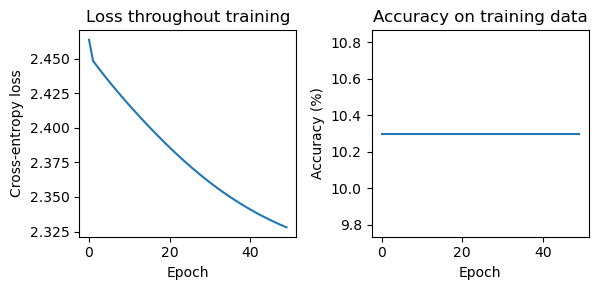

In [12]:
utils.plot_performance_training(losses, accuracies)

**Exercise**: Create a model with a 10 neurons in the hidden layer (`hidden_layer_size = 10`) and a ReLU activation function after the hidden layer.

In [29]:
hidden_layer_size = 10

torch.manual_seed(SEED)
# create model
model = nn.Sequential(
    nn.Linear(n_in_features, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, n_classes)
)
model

Sequential(
  (0): Linear(in_features=3072, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
)

Train the model for `50` epochs using `utils.train`. Run the second cell to plot the accuracy and loss throughout training.

In [30]:
losses, accuracies = utils.train(model, features_train, labels_train, nepochs=50)

Epoch: 0, Loss: 2.33, Train accuracy: 9.76


Epoch: 10, Loss: 2.32, Train accuracy: 9.37
Epoch: 20, Loss: 2.32, Train accuracy: 9.37
Epoch: 30, Loss: 2.31, Train accuracy: 9.74
Epoch: 40, Loss: 2.31, Train accuracy: 9.74


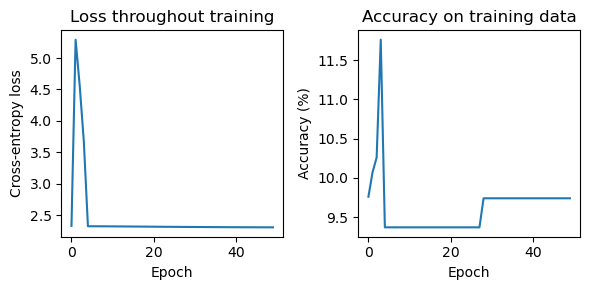

In [31]:
utils.plot_performance_training(losses, accuracies)

**Exercise**: Create a model with a 100 neurons in the hidden layer (`hidden_layer_size = 100`) and a ReLU activation function after the hidden layer.

In [32]:
hidden_layer_size = 110

torch.manual_seed(SEED)
# create model
model = nn.Sequential(
    nn.Linear(n_in_features, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, n_classes)
)
model

Sequential(
  (0): Linear(in_features=3072, out_features=110, bias=True)
  (1): ReLU()
  (2): Linear(in_features=110, out_features=10, bias=True)
)

Train the model for `50` epochs using `utils.train`. Run the second cell to plot the accuracy and loss throughout training.

In [17]:
losses, accuracies = utils.train(model, features_train, labels_train, nepochs=50)

Epoch: 0, Loss: 2.33, Train accuracy: 10.02
Epoch: 10, Loss: 4.61, Train accuracy: 13.70
Epoch: 20, Loss: 2.30, Train accuracy: 9.37
Epoch: 30, Loss: 2.30, Train accuracy: 9.37
Epoch: 40, Loss: 2.30, Train accuracy: 9.37


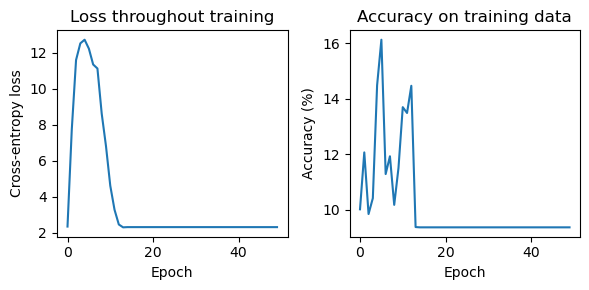

In [18]:
utils.plot_performance_training(losses, accuracies)

We should investigate if the model performs better if we train it longer. But training a model with many parameters for many epochs on a fairly complex dataset can take a long of time, especially without GPUs. Therefore, we have pretrained a model with a 100 neurons in the hidden layer for 1000 epochs. You can load the loss and accuracy throughout that training by running the cell below.

In [33]:
losses = df[df.source == '100hidden_1000epochs']['losses']
accuracies = df[df.source == '100hidden_1000epochs']['accuracies']

**Exercise**: Plot the loss and the accuracy throughout training loaded for the model with a 100 neurons that was trained for 1000 epochs.

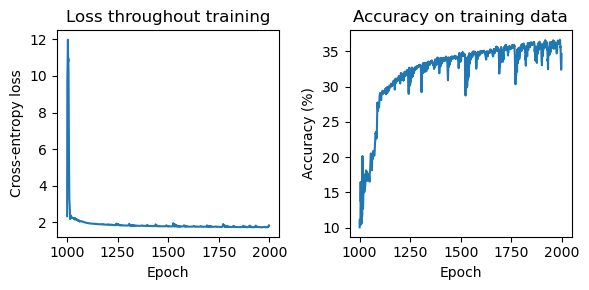

In [34]:
utils.plot_performance_training(losses, accuracies)

## Section 2: Effect of Making Networks Deeper

A neural network's depth refers to the number of hidden layers. Deeper networks can learn hierarchical representations of data, where early layers capture simple patterns and later layers combine these into more complex features. In this section, you will explore how adding more hidden layers affects model performance.

| Code | Description |
| :-- | :-- |
| `model = nn.Sequential(`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.Linear(100,20),`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.ReLU(),`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.Linear(20,10),`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.ReLU(),`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.Linear(10,1)`<br>`)` | Assigns a the container to a variable `model`. This model has 100 input features, two hidden layers with 20 and 10 nodes, respectively, and 3 output features. |
| `utils.calculate_accuracy(model, features_test, labels_test)` | Calculate accuracy on test data to evaluate generalization. |

#### **Exercises**

Run cell below to define number of input features and number of classes to classify for models in this section and to create the SEED.

In [21]:
n_in_features = 32 * 32 * 3  # CIFAR-10 images flattened
n_classes = 10  # CIFAR-10 has 10 classes
SEED = 2026

**Example**: Create a model with two hidden layers and 10 neurons in each hidden layer (`hidden_layer_size = 10`) and a ReLU activation function after each the hidden layer.

In [22]:
hidden_layer_size = 10

# create model
torch.manual_seed(SEED)

model = nn.Sequential(
    nn.Linear(n_in_features, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, n_classes)
)
model

Sequential(
  (0): Linear(in_features=3072, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
)

Train the model for 50 epochs using `utils.train`. Run the second cell to plot the accuracy and loss throughout training.

In [23]:
losses, accuracies = utils.train(model, features_train, labels_train, nepochs=50)

Epoch: 0, Loss: 2.32, Train accuracy: 9.81
Epoch: 10, Loss: 2.35, Train accuracy: 10.56
Epoch: 20, Loss: 2.32, Train accuracy: 10.32
Epoch: 30, Loss: 2.31, Train accuracy: 10.32
Epoch: 40, Loss: 2.29, Train accuracy: 10.66


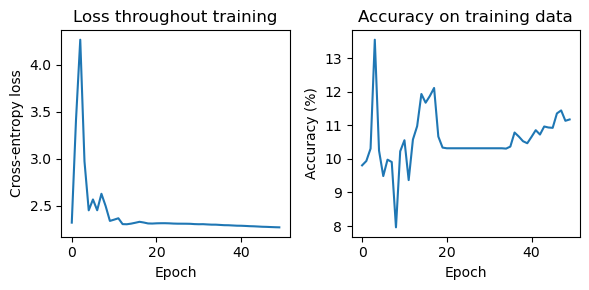

In [24]:
utils.plot_performance_training(losses, accuracies)

**Exercise**: Create a model with 4 hidden layers and 10 neurons in each hidden layer (`hidden_layer_size = 10`) and a ReLU activation function after each the hidden layer.

In [25]:
hidden_layer_size = 10

# create model
torch.manual_seed(SEED)

model = nn.Sequential(
    nn.Linear(n_in_features, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, n_classes)
)
model

Sequential(
  (0): Linear(in_features=3072, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=10, bias=True)
  (7): ReLU()
  (8): Linear(in_features=10, out_features=10, bias=True)
)

Train the model for 50 epochs using `utils.train`. Run the second cell to plot the accuracy and loss throughout training.

In [26]:
losses, accuracies = utils.train(model, features_train, labels_train, nepochs=50)

Epoch: 0, Loss: 2.32, Train accuracy: 10.30


Epoch: 10, Loss: 2.29, Train accuracy: 16.23
Epoch: 20, Loss: 2.16, Train accuracy: 14.93
Epoch: 30, Loss: 2.07, Train accuracy: 19.59
Epoch: 40, Loss: 2.06, Train accuracy: 19.91


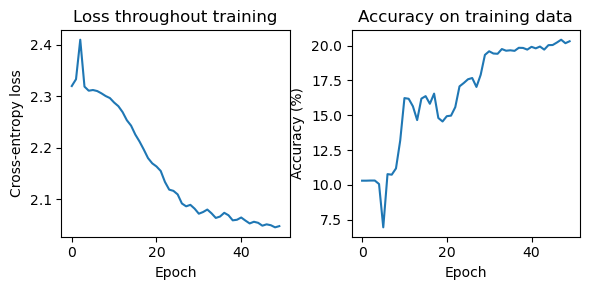

In [27]:
utils.plot_performance_training(losses, accuracies)

The models with 4 hidden layers reached a higher accuracy on the training data than the model with a single layer and 100 neurons for the same number of epochs. To save you some time, we've pretrained the same model for a 1000 epochs. You can load the accuracy and losses throughout training by running the cell below.

In [27]:
losses = df[df.source == '4layers_10hidden_1000epochs']['losses']
accuracies = df[df.source == '4layers_10hidden_1000epochs']['accuracies']

**Exercise**: Plot the loss and the accuracy throughout training loaded for the model with a 4 layers of 10 neurons that was trained for 1000 epochs. What's (approximately) the highest accuracy it reaches?

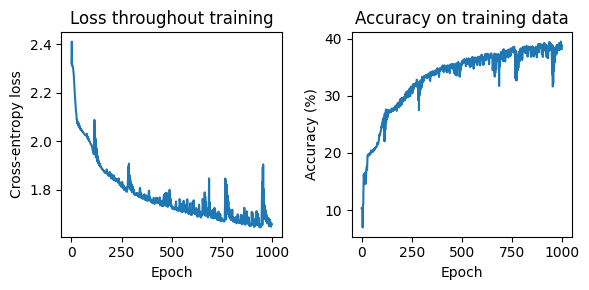

In [28]:
utils.plot_performance_training(losses, accuracies)

The model with 4 layers and 10 hidden neurons per layer seems to perform better than the single layer with 100 neurons, so let's try making the model even deeper.

**Exercise**: Create a new model with 8 hidden layers and 10 neurons per layer.

In [29]:
hidden_layer_size = 10

# create model
torch.manual_seed(SEED)

model = nn.Sequential(
    nn.Linear(n_in_features, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, n_classes)
)
model

Sequential(
  (0): Linear(in_features=3072, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=10, bias=True)
  (7): ReLU()
  (8): Linear(in_features=10, out_features=10, bias=True)
  (9): ReLU()
  (10): Linear(in_features=10, out_features=10, bias=True)
  (11): ReLU()
  (12): Linear(in_features=10, out_features=10, bias=True)
  (13): ReLU()
  (14): Linear(in_features=10, out_features=10, bias=True)
  (15): ReLU()
  (16): Linear(in_features=10, out_features=10, bias=True)
)

Run the cell below to load the losses and accuracies throughout training of the model with 8 hidden layers and 10 neurons per layer for 1000 epochs. 

In [30]:
losses = df[df.source == '8layers_10hidden_1000epochs']['losses']
accuracies = df[df.source == '8layers_10hidden_1000epochs']['accuracies']

**Exercise**: Plot the loss and the accuracy throughout training loaded. What's (approximately) the highest accuracy it reaches?

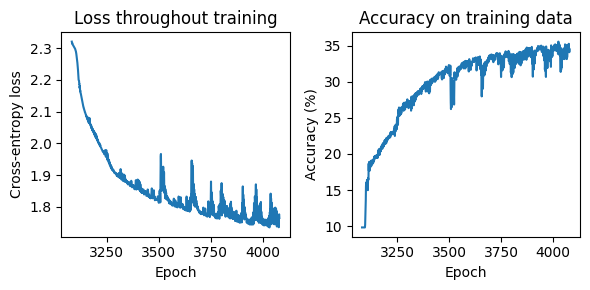

In [31]:
utils.plot_performance_training(losses, accuracies)

The model's performance appears to not improve anymore just by adding even more layers, so let's try a combination of width and depth.

**Exercise**: Create a model with 4 hidden layers with 80 neurons in each hidden layer.

In [32]:
hidden_layer_size = 80

# create model
torch.manual_seed(SEED)

model = nn.Sequential(
    nn.Linear(n_in_features, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, n_classes)
)
model

Sequential(
  (0): Linear(in_features=3072, out_features=80, bias=True)
  (1): ReLU()
  (2): Linear(in_features=80, out_features=80, bias=True)
  (3): ReLU()
  (4): Linear(in_features=80, out_features=80, bias=True)
  (5): ReLU()
  (6): Linear(in_features=80, out_features=80, bias=True)
  (7): ReLU()
  (8): Linear(in_features=80, out_features=10, bias=True)
)

Run the cell below to load the model with 4 hidden layers and 80 neurons in each layer pretrained for 1000 epochs as well as the losses and accuracies throughout training. 

In [39]:
# Load model
model = torch.load('models/model_4layers_80hidden_neurons_1000epochs.pth', weights_only=False)
print("Model loaded successfully")

losses = df[df.source == '4layers_80hidden_1000epochs']['losses']
accuracies = df[df.source == '4layers_80hidden_1000epochs']['accuracies']

Model loaded successfully


**Exercise**: Plot the loaded loss and the accuracy throughout training. What's (approximately) the highest accuracy it reaches?

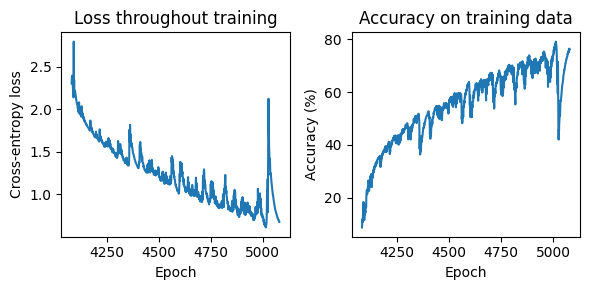

In [40]:
utils.plot_performance_training(losses, accuracies)

For this dataset, a wide but shallow model did not reach a high accuracy. A deep but narrow model also didn't reach a high accuracy. A combination - a somewhat wide **and** deep model achieved the highest accuracy. The reason is not that the wide and deep model has more parameters - it doesn't. One reason is that a certain width is required to avoid information bottlenecks (which a deep but narrow model has). Another reason is that as soon as you have a wide enough network, the additional activation functions that come with more depth allows the model to identify more complex decision boundaries.

---

The performance of the last model on the training data is quite good. But it's possible that the model only memorizes patterns specific to the training dataset instead of learning generalizable patterns. This is referred to as overfitting, and means that the model won't be useful for any other data than the training dataset.

To investigate how well the model generalizes, we should also check the model's performance on data that it didn't see during training. This subdataset is referred to as the test dataset. If the accuracy is low on the test dataset (and substantially lower than the accuracy on the training data), that suggests that the model does not generalize well.

**Exercise**: Calculate the accuracy of the final model on the test dataset (`features_test` and `labels_test`). Feel free to use the utility function `utils.calculate_accuracy`. How high was the accuracy on the test dataset? You'll learn about how to assess and deal with overfitting in later sessions.

In [41]:
utils.calculate_accuracy(model, features_test, labels_test)

Accuracy: 39.349998474121094


39.349998474121094

## Section 3: Batch Normalization

We observed above that the model needed quite many epochs to reach a low loss and high accuracy. One reason why for this is that the inputs to each layer changes during training as the weights in earlier layers are updated. This phenomenon is called internal covariate shift, and it can slow down training significantly. Batch normalization addresses this by normalizing the inputs to each layer, ensuring they have a mean of 0 and a standard deviation of 1. This stabilizes training and often allows for faster convergence.

| Code | Description |
| :-- | :-- |
| `nn.BatchNorm1d(num_features)` | Batch normalization layer for 1D inputs with `num_features` features. |
| `nn.Sequential(`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.Linear(in_features, hidden_size),`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.BatchNorm1d(hidden_size),`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.ReLU(),`<br>&nbsp;&nbsp;&nbsp;&nbsp;`...`<br>`)` | Typical ordering: Linear layer, then BatchNorm, then activation function. |
| `model.eval()` | Set model to evaluation mode - used to turn off batchnorm before accuracy is calculated on test data. |
| `utils.train(model, features_train, labels_train, nepochs=50)` | Train the model for `50` epochs. |
| `utils.calculate_accuracy(model, features_test, labels_test)` | Calculate accuracy on test data. |

#### **Exercises**

Run cell below to define number of input features and number of classes to classify for models in this section and to create the SEED.

In [42]:
n_in_features = 32 * 32 * 3  # CIFAR-10 images flattened
n_classes = 10  # CIFAR-10 has 10 classes
SEED = 2026

**Example**: Create a model with a single hidden layer and 100 neurons per layer **with** batch normalization. Name the model `model_bn`.

In [43]:
hidden_layer_size = 100

# create model with batch normalization
torch.manual_seed(SEED)

model_bn = nn.Sequential(
    nn.Linear(n_in_features, hidden_layer_size),
    nn.BatchNorm1d(hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, n_classes)
)
model_bn

Sequential(
  (0): Linear(in_features=3072, out_features=100, bias=True)
  (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=10, bias=True)
)

**Exercise**: Create a model with a **two** hidden layers and 100 neurons per layer **with** batch normalization. Note that batch normalization should be added after each hidden layer.

In [44]:
hidden_layer_size = 100

# create model with batch normalization
torch.manual_seed(SEED)

model_bn = nn.Sequential(
    nn.Linear(n_in_features, hidden_layer_size),
    nn.BatchNorm1d(hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, n_classes)
)
model_bn

Sequential(
  (0): Linear(in_features=3072, out_features=100, bias=True)
  (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=10, bias=True)
)

**Exercise**: Create a model with the 4 hidden layers **with** batch normalization. Name the model `model_bn`. Remember to add batch normalization after each hidden layer.

In [45]:
hidden_layer_size = 100

# create model with batch normalization
torch.manual_seed(SEED)

model_bn = nn.Sequential(
    nn.Linear(n_in_features, hidden_layer_size),
    nn.BatchNorm1d(hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, hidden_layer_size),
    nn.BatchNorm1d(hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, hidden_layer_size),
    nn.BatchNorm1d(hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, hidden_layer_size),
    nn.BatchNorm1d(hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, n_classes)
)
model_bn

Sequential(
  (0): Linear(in_features=3072, out_features=100, bias=True)
  (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=100, out_features=10, bias=True)
)

**Exercise**: Train the model with 4 hidden layers and batch normalization for 81 epochs using `utils.train`. Then run the cell that plots the accuracy and loss throughout training. What's (approximately) the highest accuracy reached?

**Note**: If it takes a long time to train the model, you can interrupt the cell (by clicking the button that says "interrupt" in the tool bar) and load the pretrained model and results below.

In [46]:
losses_bn, accuracies_bn = utils.train(model_bn, features_train, labels_train, nepochs=81)

Epoch: 0, Loss: 2.36, Train accuracy: 17.25
Epoch: 10, Loss: 1.70, Train accuracy: 39.67
Epoch: 20, Loss: 1.52, Train accuracy: 45.13
Epoch: 30, Loss: 1.35, Train accuracy: 51.16
Epoch: 40, Loss: 1.22, Train accuracy: 56.64
Epoch: 50, Loss: 1.05, Train accuracy: 63.77
Epoch: 60, Loss: 0.86, Train accuracy: 67.85
Epoch: 70, Loss: 0.69, Train accuracy: 77.60
Epoch: 80, Loss: 0.50, Train accuracy: 82.36


In [48]:
# load model
model_bn = torch.load('models/model_with_batchnorm_4layers_100hidden_neurons_81epochs.pth', weights_only=False)
print("Model loaded successfully")

# load results
losses_bn = df[df.source == 'with_batchnorm_4layers_100hidden_81epochs']['losses']
accuracies_bn = df[df.source == 'with_batchnorm_4layers_100hidden_81epochs']['accuracies']
model_bn

Model loaded successfully


Sequential(
  (0): Linear(in_features=3072, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=10, bias=True)
  (7): ReLU()
  (8): Linear(in_features=10, out_features=10, bias=True)
)

**Demo**: Run the next cell to load a the losses and accuracies from training the same model **without** batch normalization.

In [49]:
losses_no_bn = df[df.source == '4layers_100hidden_81epochs']['losses']
accuracies_no_bn = df[df.source == '4layers_100hidden_81epochs']['accuracies']

Run the cell below to compare the training curves of the model with and without batch normalization side by side. Which model reaches higher accuracy faster?

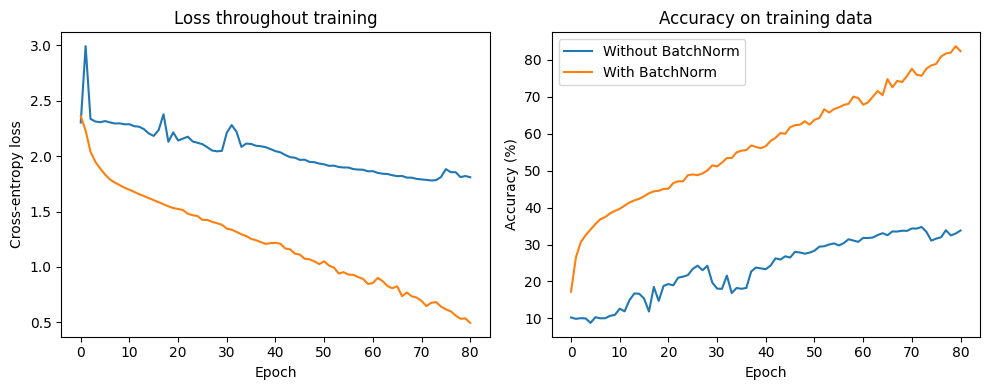

In [50]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

axes[0].plot(losses_no_bn.values, label='Without BatchNorm')
axes[0].plot(losses_bn.values, label='With BatchNorm')
axes[0].set_title('Loss throughout training')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Cross-entropy loss')

axes[1].plot(accuracies_no_bn.values, label='Without BatchNorm')
axes[1].plot(accuracies_bn.values, label='With BatchNorm')
axes[1].set_title('Accuracy on training data')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()

fig.tight_layout()